In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Initialising the resnet50 model with weights on the ImageNet Dataset. 

In [44]:
from keras.models import Model
from keras.layers import Dense, Input, Activation, Flatten, GlobalAveragePooling2D, LeakyReLU
from keras.applications.resnet50 import ResNet50
from sklearn.model_selection import train_test_split

import cv2
import numpy as np
import keras
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import os
import random
import pickle

In [2]:
# The sign Language dataset has images of shape 200 x 200 x 3 (colour)
# we will be experimenting with different image sizes as 200 is extremely large
# for a dataset such as this

my_input_image = Input(shape=(120,120,3))

# include_top = True means to include the top level layers that make the prediction
# we will remove their prediction layer but this is just to show properly how its done. 
model = ResNet50(input_tensor=my_input_image,include_top=True, weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 120, 120, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 126, 126, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 60, 60, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 60, 60, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

### Add on our own layers to the model
##### The plan here is to remove the last three layers (refer to model.summary() above) and add on our layers from 'add_32' layer. 

add on our layers

the plan is to add a activation layer, the test with the following methods

##### method 1:
+ add flatten(), 
+ add multiple Dense(),
+ add final Dense() with softmax activation. 

##### method 2:
+ add GlobalAveragePooling() 
+ add multiple Dense()
+ add final Dense() with softmax activation.

##### method 3:
+ remove only last layer
+ add only Dense() with softmax activation. 

method 2 is more related to how they did it originally with the addition to a few Denses. 

They also use activation but I will be trying with different activation fucntions to see 
if they have any affect on performance. 

If there is no significant affect to accuracy then I will use their activation layer and add my own layers.


### Method 1:

In [56]:
# take output from the add_32 layer
add_32 = model.get_layer('add_16').output

In [57]:
activation = 'elu'

activation_1 = Activation(LeakyReLU())(add_32)
flatten_1 = Flatten()(activation_1)
dense_1 = Dense(1000, activation=activation)(flatten_1)
dense_2 = Dense(500, activation=activation)(dense_1)
dense_3 = Dense(250, activation=activation)(dense_2)
dense_4 = Dense(100, activation=activation)(dense_3)
output = Dense(29, activation='softmax')(dense_3)

my_resnet_model_1 = Model(inputs=my_input_image, outputs= output)
my_resnet_model_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 120, 120, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 126, 126, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 60, 60, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 60, 60, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

C:\Users\black\Miniconda3\envs\random\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [58]:
for layer in my_resnet_model_1.layers[:-6]:
    layer.trainable = False
    
for layer in my_resnet_model_1.layers:
    print(layer.name, layer.trainable)

input_1 False
conv1_pad False
conv1 False
bn_conv1 False
activation_1 False
pool1_pad False
max_pooling2d_1 False
res2a_branch2a False
bn2a_branch2a False
activation_2 False
res2a_branch2b False
bn2a_branch2b False
activation_3 False
res2a_branch2c False
res2a_branch1 False
bn2a_branch2c False
bn2a_branch1 False
add_1 False
activation_4 False
res2b_branch2a False
bn2b_branch2a False
activation_5 False
res2b_branch2b False
bn2b_branch2b False
activation_6 False
res2b_branch2c False
bn2b_branch2c False
add_2 False
activation_7 False
res2c_branch2a False
bn2c_branch2a False
activation_8 False
res2c_branch2b False
bn2c_branch2b False
activation_9 False
res2c_branch2c False
bn2c_branch2c False
add_3 False
activation_10 False
res3a_branch2a False
bn3a_branch2a False
activation_11 False
res3a_branch2b False
bn3a_branch2b False
activation_12 False
res3a_branch2c False
res3a_branch1 False
bn3a_branch2c False
bn3a_branch1 False
add_4 False
activation_13 False
res3b_branch2a False
bn3b_branch2a F

### Method 2:

In [59]:
add_32 = model.get_layer('add_16').output

In [60]:
activation = 'elu'

activation_1 = Activation(LeakyReLU())(add_32)
GAP_1 = GlobalAveragePooling2D()(activation_1)
dense_1 = Dense(1000, activation=activation)(GAP_1)
dense_2 = Dense(500, activation=activation)(dense_1)
dense_3 = Dense(250, activation=activation)(dense_2)
dense_4 = Dense(100, activation=activation)(dense_3)
output = Dense(29, activation='softmax')(dense_3)

my_resnet_model_2 = Model(inputs=my_input_image, outputs= output)
my_resnet_model_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 120, 120, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 126, 126, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 60, 60, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 60, 60, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [61]:
for layer in my_resnet_model_2.layers[:-6]:
    layer.trainable = False
    
for layer in my_resnet_model_2.layers:
    print(layer.name, layer.trainable)

input_1 False
conv1_pad False
conv1 False
bn_conv1 False
activation_1 False
pool1_pad False
max_pooling2d_1 False
res2a_branch2a False
bn2a_branch2a False
activation_2 False
res2a_branch2b False
bn2a_branch2b False
activation_3 False
res2a_branch2c False
res2a_branch1 False
bn2a_branch2c False
bn2a_branch1 False
add_1 False
activation_4 False
res2b_branch2a False
bn2b_branch2a False
activation_5 False
res2b_branch2b False
bn2b_branch2b False
activation_6 False
res2b_branch2c False
bn2b_branch2c False
add_2 False
activation_7 False
res2c_branch2a False
bn2c_branch2a False
activation_8 False
res2c_branch2b False
bn2c_branch2b False
activation_9 False
res2c_branch2c False
bn2c_branch2c False
add_3 False
activation_10 False
res3a_branch2a False
bn3a_branch2a False
activation_11 False
res3a_branch2b False
bn3a_branch2b False
activation_12 False
res3a_branch2c False
res3a_branch1 False
bn3a_branch2c False
bn3a_branch1 False
add_4 False
activation_13 False
res3b_branch2a False
bn3b_branch2a F

### Method 3:

In [29]:
avg_pool = model.get_layer('avg_pool').output

In [30]:
output = Dense(29, activation='softmax')(avg_pool)

my_resnet_model_3 = Model(inputs=my_input_image, outputs= output)
my_resnet_model_3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 120, 120, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 126, 126, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 60, 60, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 60, 60, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [31]:
for layer in my_resnet_model_3.layers[:-1]:
    layer.trainable = False
    
for layer in my_resnet_model_3.layers:
    print(layer.name, layer.trainable)

input_1 False
conv1_pad False
conv1 False
bn_conv1 False
activation_1 False
pool1_pad False
max_pooling2d_1 False
res2a_branch2a False
bn2a_branch2a False
activation_2 False
res2a_branch2b False
bn2a_branch2b False
activation_3 False
res2a_branch2c False
res2a_branch1 False
bn2a_branch2c False
bn2a_branch1 False
add_1 False
activation_4 False
res2b_branch2a False
bn2b_branch2a False
activation_5 False
res2b_branch2b False
bn2b_branch2b False
activation_6 False
res2b_branch2c False
bn2b_branch2c False
add_2 False
activation_7 False
res2c_branch2a False
bn2c_branch2a False
activation_8 False
res2c_branch2b False
bn2c_branch2b False
activation_9 False
res2c_branch2c False
bn2c_branch2c False
add_3 False
activation_10 False
res3a_branch2a False
bn3a_branch2a False
activation_11 False
res3a_branch2b False
bn3a_branch2b False
activation_12 False
res3a_branch2c False
res3a_branch1 False
bn3a_branch2c False
bn3a_branch1 False
add_4 False
activation_13 False
res3b_branch2a False
bn3b_branch2a F

# Load the data


In [15]:
#init img_size 

img_size = 120

In [16]:
# init the directories and all the possible classes we can have. We will use these classes as our class label too. 
asl_dataset_dir = 'asl_alphabet_train/'
asl_catagories = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space']

In [17]:
training_data = []

for category in asl_catagories:
    path = os.path.join(asl_dataset_dir, category) # creates the whole path to each sub dir
    class_num = asl_catagories.index(category)
    
    print(category) # Debug
    
    for img in os.listdir(path):
        
        img_array = cv2.imread(os.path.join(path, img), 1)
        
        img_array = cv2.resize(img_array, (img_size,img_size))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        
        training_data.append([img_array, class_num])
    

A
B
C
D
E
F
G
H
I
J
K
L
M
N
O
P
Q
R
S
T
U
V
W
X
Y
Z
del
nothing
space


In [18]:
random.shuffle(training_data)

X = [] # feature set
Y = [] # label set

for feature, label in training_data:
    X.append(feature)
    Y.append(label)
    

In [19]:
with open('X.pickle', 'wb') as X_out:
    pickle.dump(X, X_out, protocol=4)
    
with open('Y.pickle', 'wb') as Y_out:
    pickle.dump(Y, Y_out, protocol=4)

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=69)

In [21]:
X_train = np.array(X_train).reshape(-1, img_size, img_size, 3)
X_test = np.array(X_test).reshape(-1, img_size, img_size, 3)

Y_train, Y_test = np.array(Y_train), np.array(Y_test)

In [22]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(69580, 120, 120, 3) (17396, 120, 120, 3) (69580,) (17396,)


# Fit both models on ASL data

In [62]:
# compile model
my_resnet_model_1.compile('sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [63]:
history_model_1 = my_resnet_model_1.fit(X_train, Y_train, epochs=10, batch_size=64, validation_split=0.2)

Train on 55664 samples, validate on 13916 samples
Epoch 1/10
55664/55664 [==============================] - 131s 2ms/step - loss: 0.1979 - acc: 0.9443 - val_loss: 1.7388 - val_acc: 0.5617
Epoch 2/10
55664/55664 [==============================] - 126s 2ms/step - loss: 0.0118 - acc: 0.9976 - val_loss: 1.7029 - val_acc: 0.5807
Epoch 3/10
55664/55664 [==============================] - 127s 2ms/step - loss: 0.0051 - acc: 0.9994 - val_loss: 1.7108 - val_acc: 0.5881
Epoch 4/10
55664/55664 [==============================] - 127s 2ms/step - loss: 0.0031 - acc: 0.9997 - val_loss: 1.7511 - val_acc: 0.5858
Epoch 5/10
55664/55664 [==============================] - 127s 2ms/step - loss: 0.0022 - acc: 0.9998 - val_loss: 1.7419 - val_acc: 0.5942
Epoch 6/10
55664/55664 [==============================] - 127s 2ms/step - loss: 0.0014 - acc: 0.9999 - val_loss: 1.7687 - val_acc: 0.5923
Epoch 7/10
55664/55664 [==============================] - 127s 2ms/step - loss: 0.0012 - acc: 0.9999 - val_loss: 1.7958 - 

In [64]:
# compile model
my_resnet_model_2.compile('sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [65]:
history_model_2 = my_resnet_model_2.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)

Train on 55664 samples, validate on 13916 samples
Epoch 1/10
55664/55664 [==============================] - 134s 2ms/step - loss: 0.4913 - acc: 0.8663 - val_loss: 1.9377 - val_acc: 0.4557
Epoch 2/10
55664/55664 [==============================] - 132s 2ms/step - loss: 0.1338 - acc: 0.9614 - val_loss: 2.1861 - val_acc: 0.4528
Epoch 3/10
55664/55664 [==============================] - 131s 2ms/step - loss: 0.0820 - acc: 0.9772 - val_loss: 2.2850 - val_acc: 0.4515
Epoch 4/10
55664/55664 [==============================] - 131s 2ms/step - loss: 0.0621 - acc: 0.9819 - val_loss: 2.4126 - val_acc: 0.4462
Epoch 5/10
55664/55664 [==============================] - 131s 2ms/step - loss: 0.0474 - acc: 0.9863 - val_loss: 2.6403 - val_acc: 0.4343
Epoch 6/10
55664/55664 [==============================] - 131s 2ms/step - loss: 0.0376 - acc: 0.9899 - val_loss: 2.8175 - val_acc: 0.4181
Epoch 7/10
55664/55664 [==============================] - 131s 2ms/step - loss: 0.0323 - acc: 0.9909 - val_loss: 2.5843 - 

In [48]:
# compile model
my_resnet_model_3.compile('sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [49]:
history_model_3 = my_resnet_model_3.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)

Train on 55664 samples, validate on 13916 samples
Epoch 1/10
55664/55664 [==============================] - 131s 2ms/step - loss: 0.1062 - acc: 0.9812 - val_loss: 1.8014 - val_acc: 0.5346
Epoch 2/10
55664/55664 [==============================] - 129s 2ms/step - loss: 0.0999 - acc: 0.9825 - val_loss: 1.8623 - val_acc: 0.5269
Epoch 3/10
55664/55664 [==============================] - 129s 2ms/step - loss: 0.0952 - acc: 0.9832 - val_loss: 1.8410 - val_acc: 0.5290
Epoch 4/10
55664/55664 [==============================] - 129s 2ms/step - loss: 0.0909 - acc: 0.9836 - val_loss: 1.8417 - val_acc: 0.5300
Epoch 5/10
55664/55664 [==============================] - 128s 2ms/step - loss: 0.0857 - acc: 0.9856 - val_loss: 1.8295 - val_acc: 0.5354
Epoch 6/10
55664/55664 [==============================] - 129s 2ms/step - loss: 0.0808 - acc: 0.9864 - val_loss: 1.8492 - val_acc: 0.5326
Epoch 7/10
55664/55664 [==============================] - 131s 2ms/step - loss: 0.0780 - acc: 0.9868 - val_loss: 1.8849 - 

# Plotting outputs 

In [50]:
train_loss_1 = history_model_1.history['loss']
val_loss_1 = history_model_1.history['val_loss']

Text(0.5, 1.0, 'Comparing train and val loss of method 1')

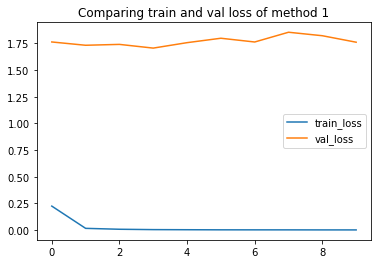

In [51]:
plt.plot(train_loss_1)
plt.plot(val_loss_1)

plt.legend(('train_loss', 'val_loss'))
plt.title('Comparing train and val loss of method 1')

In [52]:
train_loss_2 = history_model_2.history['loss']
val_loss_2 = history_model_2.history['val_loss']

Text(0.5, 1.0, 'Comparing train and val loss of method 2')

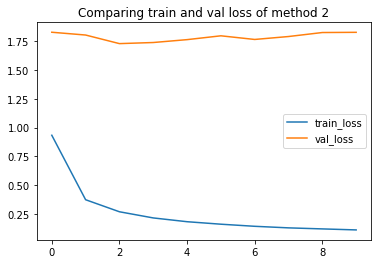

In [53]:
plt.plot(train_loss_2)
plt.plot(val_loss_2)

plt.legend(('train_loss', 'val_loss'))
plt.title('Comparing train and val loss of method 2')

In [54]:
train_loss_3 = history_model_3.history['loss']
val_loss_3 = history_model_3.history['val_loss']

Text(0.5, 1.0, 'Comparing train and val loss of method 3')

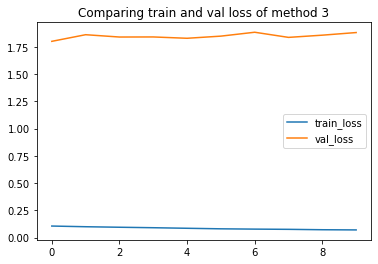

In [55]:
plt.plot(train_loss_3)
plt.plot(val_loss_3)

plt.legend(('train_loss', 'val_loss'))
plt.title('Comparing train and val loss of method 3')